# Atmospheric, oceanic and land data handling

In this notebook we discuss the subtleties of how netCDF-SCM handles different data 'realms' and why these choices are made. The realms of interest are atmosphere, ocean and land and the distinction between the realms follows the [CMIP6 realm controlled vocabulary](https://github.com/WCRP-CMIP/CMIP6_CVs/blob/master/CMIP6_realm.json).

In [1]:
# NBVAL_IGNORE_OUTPUT
import traceback
from os.path import join

import iris
import iris.quickplot as qplt
import matplotlib.pyplot as plt
import numpy as np

from netcdf_scm.iris_cube_wrappers import CMIP6OutputCube
from netcdf_scm.utils import broadcast_onto_lat_lon_grid

In [2]:
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()
plt.style.use("bmh")

In [3]:
import logging

logging.captureWarnings(True)

root_logger = logging.getLogger()
root_logger.setLevel(logging.WARNING)
fmt = logging.Formatter("{levelname}:{name}:{message}", style="{")
stream_handler = logging.StreamHandler()
stream_handler.setFormatter(fmt)
root_logger.addHandler(stream_handler)

In [4]:
DATA_PATH_TEST = join("..", "..", "..", "tests", "test-data")

Note that all of our data is on a regular grid, we show an example of using native model grid data in the ocean section.

In [5]:
tas_file = join(
    DATA_PATH_TEST,
    "cmip6output",
    "CMIP6",
    "CMIP",
    "IPSL",
    "IPSL-CM6A-LR",
    "historical",
    "r1i1p1f1",
    "Amon",
    "tas",
    "gr",
    "v20180803",
    "tas_Amon_IPSL-CM6A-LR_historical_r1i1p1f1_gr_191001-191003.nc",
)

gpp_file = tas_file.replace("Amon", "Lmon").replace("tas", "gpp")
csoilfast_file = gpp_file.replace("gpp", "cSoilFast")

hfds_file = join(
    DATA_PATH_TEST,
    "cmip6output",
    "CMIP6",
    "CMIP",
    "NOAA-GFDL",
    "GFDL-CM4",
    "piControl",
    "r1i1p1f1",
    "Omon",
    "hfds",
    "gr",
    "v20180701",
    "hfds_Omon_GFDL-CM4_piControl_r1i1p1f1_gr_015101-015103.nc",
)

## Oceans

We start by loading our data.

In [6]:
# NBVAL_IGNORE_OUTPUT
hfds = CMIP6OutputCube()
hfds.load_data_from_path(hfds_file)

netCDF-SCM will assume whether the data is "ocean", "land" or "atmosphere". The assumed realm can be checked by examining a `ScmCube`'s `netcdf_scm_realm` property.

In our case we have "ocean" data.

In [7]:
hfds.netcdf_scm_realm

'ocean'

If we have ocean data, then there is no data which will go in a "land" box. Hence, if we request e.g. `World|Land` data, we will get a warning and land data will not be returned.

In [8]:
out = hfds.get_scm_timeseries(regions=["World", "World|Land"])
out["region"].unique()

  warnings.warn(warn_str)



array(['World'], dtype=object)

As there is no land data, the `World` mean is equal to the `World|Ocean` mean.

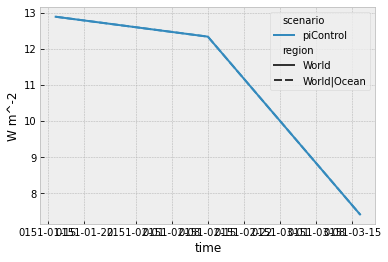

In [9]:
# NBVAL_IGNORE_OUTPUT
hfds_scm_ts = hfds.get_scm_timeseries(regions=["World", "World|Ocean"])
hfds_scm_ts.line_plot(style="region")
np.testing.assert_allclose(
    hfds_scm_ts.filter(region="World").values,
    hfds_scm_ts.filter(region="World|Ocean").values,
);

When taking averages, there are 3 obvious options:

- unweighted average
- area weighted average
- area and surface fraction weighted average

In netCDF-SCM, we provide the choice of the first two (if you want an unweighted average, please raise an issue on our [issue tracker](https://gitlab.com/netcdf-scm/netcdf-scm/-/issues)). Depending on the context, one will likely make more sense than the other. The user can specify this to ``ScmCube.get_scm_timeseries_weights`` via the ``cell_weights`` argument. If the user doesn't supply a value, ``ScmCube`` will guess depending on what is most appropriate, see the docstring below for more details.

In [10]:
print(hfds.get_scm_timeseries_weights.__doc__)


        Get the scm timeseries weights

        Parameters
        ----------
        surface_fraction_cube : :obj:`ScmCube`, optional
            land surface fraction data which is used to determine whether a given
            gridbox is land or ocean. If ``None``, we try to load the land surface fraction automatically.

        areacell_scmcube : :obj:`ScmCube`, optional
            cell area data which is used to take the latitude-longitude mean of the
            cube's data. If ``None``, we try to load this data automatically and if
            that fails we fall back onto ``iris.analysis.cartography.area_weights``.

        regions : list[str]
            List of regions to use. If ``None`` then
            ``netcdf_scm.regions.DEFAULT_REGIONS`` is used.

        cell_weights : {'area-only', 'area-surface-fraction'}
            How cell weights should be calculated. If ``'area-surface-fraction'``, both cell area and its
            surface fraction will be used to weight the ce

In the cells below, we show the difference the choice of cell weighting makes makes.

In [11]:
def compare_weighting_options(input_scm_cube):
    unweighted_mean = input_scm_cube.cube.collapsed(
        ["latitude", "longitude"], iris.analysis.MEAN
    )

    area_cell = input_scm_cube.get_metadata_cube(
        input_scm_cube.areacell_var
    ).cube

    area_weights = broadcast_onto_lat_lon_grid(input_scm_cube, area_cell.data)
    area_weighted_mean = input_scm_cube.cube.collapsed(
        ["latitude", "longitude"], iris.analysis.MEAN, weights=area_weights
    )

    surface_frac = input_scm_cube.get_metadata_cube(
        input_scm_cube.surface_fraction_var
    ).cube

    area_sf = area_cell * surface_frac
    area_sf_weights = broadcast_onto_lat_lon_grid(input_scm_cube, area_sf.data)
    area_sf_weighted_mean = input_scm_cube.cube.collapsed(
        ["latitude", "longitude"], iris.analysis.MEAN, weights=area_sf_weights
    )

    plt.figure(figsize=(8, 4.5))
    qplt.plot(unweighted_mean, label="unweighted")
    qplt.plot(area_weighted_mean, label="area weighted")
    qplt.plot(
        area_sf_weighted_mean,
        label="area-surface fraction weighted",
        linestyle="--",
        dashes=(10, 10),
        linewidth=4,
    )

    plt.legend();

  warnings.warn(msg.format(coord.name()))



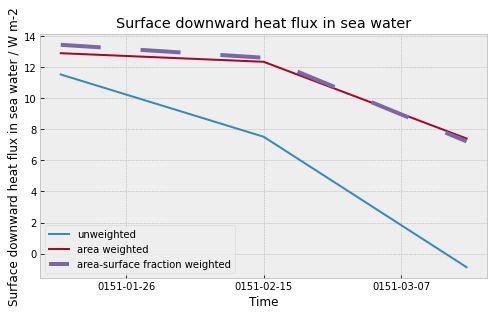

In [12]:
# NBVAL_IGNORE_OUTPUT
compare_weighting_options(hfds)

We go to the trouble of taking these area-surface fraction weightings because they matter. In particular, the area weight is required to not overweight the poles (on whatever grid we're working) whilst the surface fraction allows the user to ensure that the cells' contribution to an average reflects how much they belong in a given 'SCM box'.

### More detail

We can check which variable is being used for the cell areas by loooking at `ScmCube.areacell_var`. For ocean data this is `areacello`.

In [13]:
hfds.areacell_var

'areacello'

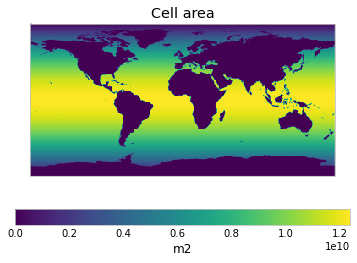

In [14]:
hfds_area_cell = hfds.get_metadata_cube(hfds.areacell_var).cube
qplt.pcolormesh(hfds_area_cell);

We can check which variable is being used for the surface fraction by loooking at `ScmCube.surface_fraction_var`. For ocean data this is `sftof`.

In [15]:
hfds.surface_fraction_var

'sftof'

In [16]:
hfds_surface_frac = hfds.get_metadata_cube(hfds.surface_fraction_var).cube
qplt.pcolormesh(hfds_surface_frac);

The product of the area of the cells and the surface fraction gives us the area-surface fraction weights. The addition of the surface fraction only really matters near the coastlines where cells are neither entirely land nor entirely ocean.

In [17]:
hfds_area_sf = hfds_area_cell * hfds_surface_frac

plt.figure(figsize=(16, 9))
plt.subplot(121)
qplt.pcolormesh(hfds_area_sf,)

plt.subplot(122)
lat_con = iris.Constraint(latitude=lambda cell: -50 < cell < -20)
lon_con = iris.Constraint(longitude=lambda cell: 140 < cell < 160)
qplt.pcolormesh(hfds_area_sf.extract(lat_con & lon_con),);

For ocean data, by default netCDF-SCM will only use the area weights. If we turn the logging up, we can see the decisions being made internally (look at the line following the line containing `cell_weights`).

In [18]:
# NBVAL_IGNORE_OUTPUT
root_logger.setLevel(logging.DEBUG)
# also load the cube again so the caching doesn't hide the logging messages
hfds = CMIP6OutputCube()
hfds.load_data_from_path(hfds_file)

DEBUG:netcdf_scm.iris_cube_wrappers:loading cube ../../../tests/test-data/cmip6output/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/piControl/r1i1p1f1/Omon/hfds/gr/v20180701/hfds_Omon_GFDL-CM4_piControl_r1i1p1f1_gr_015101-015103.nc
DEBUG:netcdf_scm.iris_cube_wrappers:loading cube ../../../tests/test-data/cmip6output/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/piControl/r1i1p1f1/Ofx/areacello/gr/v20180701/areacello_Ofx_GFDL-CM4_piControl_r1i1p1f1_gr.nc


In [19]:
# NBVAL_IGNORE_OUTPUT
hfds_area_weights = broadcast_onto_lat_lon_grid(hfds, hfds_area_cell.data)
hfds_area_weighted_mean = hfds.cube.collapsed(
    ["latitude", "longitude"], iris.analysis.MEAN, weights=hfds_area_weights
)

netcdf_scm_calculated = hfds.get_scm_timeseries(regions=["World"]).timeseries()

np.testing.assert_allclose(
    hfds_area_weighted_mean.data,
    netcdf_scm_calculated.values.squeeze(),
    rtol=1e-6,
)

netcdf_scm_calculated.T

DEBUG:netcdf_scm.iris_cube_wrappers:cell_weights: None
DEBUG:netcdf_scm.iris_cube_wrappers:self.netcdf_scm_realm: ocean
DEBUG:netcdf_scm.iris_cube_wrappers:Using: <class 'netcdf_scm.weights.AreaWeightCalculator'>
DEBUG:netcdf_scm.iris_cube_wrappers:loading cube ../../../tests/test-data/cmip6output/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/piControl/r1i1p1f1/Ofx/sftof/gr/v20180701/sftof_Ofx_GFDL-CM4_piControl_r1i1p1f1_gr.nc
DEBUG:netcdf_scm.weights:sftof data max is 100.0, dividing by 100.0 to convert units to fraction
DEBUG:netcdf_scm.iris_cube_wrappers:Crunching SCM timeseries in memory


activity_id                                               CMIP
climate_model                                         GFDL-CM4
member_id                                             r1i1p1f1
mip_era                                                  CMIP6
model                                              unspecified
region                                                   World
scenario                                             piControl
unit                                                    W m^-2
variable                                                  hfds
variable_standard_name surface_downward_heat_flux_in_sea_water
time                                                          
0151-01-16 12:00:00                                  12.899261
0151-02-15 00:00:00                                  12.346571
0151-03-16 12:00:00                                   7.410532

If we specify that surface fractions should be included, the timeseries calculated by netCDF-SCM is the same as the timeseries calculated using the surface fraction and area weights.

In [20]:
# NBVAL_IGNORE_OUTPUT
hfds_area_sf_weights = broadcast_onto_lat_lon_grid(hfds, hfds_area_sf.data)
hfds_area_sf_weighted_mean = hfds.cube.collapsed(
    ["latitude", "longitude"], iris.analysis.MEAN, weights=hfds_area_sf_weights
)

netcdf_scm_calculated = hfds.get_scm_timeseries(
    regions=["World"], cell_weights="area-surface-fraction"
).timeseries()

np.testing.assert_allclose(
    hfds_area_sf_weighted_mean.data,
    netcdf_scm_calculated.values.squeeze(),
    rtol=1e-6,
)

netcdf_scm_calculated.T

DEBUG:netcdf_scm.iris_cube_wrappers:cell_weights: area-surface-fraction
DEBUG:netcdf_scm.iris_cube_wrappers:Using: <class 'netcdf_scm.weights.AreaSurfaceFractionWeightCalculator'>
DEBUG:netcdf_scm.weights:sftof data max is 100.0, dividing by 100.0 to convert units to fraction
DEBUG:netcdf_scm.iris_cube_wrappers:Crunching SCM timeseries in memory


activity_id                                               CMIP
climate_model                                         GFDL-CM4
member_id                                             r1i1p1f1
mip_era                                                  CMIP6
model                                              unspecified
region                                                   World
scenario                                             piControl
unit                                                    W m^-2
variable                                                  hfds
variable_standard_name surface_downward_heat_flux_in_sea_water
time                                                          
0151-01-16 12:00:00                                  13.440214
0151-02-15 00:00:00                                  12.608150
0151-03-16 12:00:00                                   7.226662

In [21]:
root_logger.setLevel(logging.WARNING)

## Land

Next we look at land data.

In [22]:
gpp = CMIP6OutputCube()
gpp.load_data_from_path(gpp_file)

csoilfast = CMIP6OutputCube()
csoilfast.load_data_from_path(csoilfast_file)

In [23]:
gpp.netcdf_scm_realm

'land'

In [24]:
csoilfast.netcdf_scm_realm

'land'

If we have land data, then there is no data which will go in a "ocean" box. Hence, if we request e.g. `World|Ocean` data, we will get a warning and ocean data will not be returned.

In [25]:
out = gpp.get_scm_timeseries(regions=["World", "World|Ocean"])
out["region"].unique()

  warnings.warn(warn_str)

  warnings.warn(msg.format(self.name()))

  warnings.warn(msg.format(self.name()))



array(['World'], dtype=object)

As there is no ocean data, the `World` mean is equal to the `World|Land` mean.

In [26]:
# NBVAL_IGNORE_OUTPUT
gpp_scm_ts = gpp.get_scm_timeseries(regions=["World", "World|Land"])
gpp_scm_ts.line_plot(style="region")
np.testing.assert_allclose(
    gpp_scm_ts.filter(region="World").values,
    gpp_scm_ts.filter(region="World|Land").values,
);

  warnings.warn(msg.format(self.name()))

  warnings.warn(msg.format(self.name()))

  warnings.warn(msg.format(self.name()))

  warnings.warn(msg.format(self.name()))



In [27]:
# NBVAL_IGNORE_OUTPUT
compare_weighting_options(gpp)

  warnings.warn(msg.format(coord.name()))

  warnings.warn(msg.format(self.name()))

  warnings.warn(msg.format(self.name()))

  warnings.warn(msg.format(self.name()))

  warnings.warn(msg.format(self.name()))

  warnings.warn(msg.format(self.name()))

  warnings.warn(msg.format(self.name()))



  warnings.warn(msg.format(coord.name()))

  warnings.warn(msg.format(self.name()))

  warnings.warn(msg.format(self.name()))

  warnings.warn(msg.format(self.name()))

  warnings.warn(msg.format(self.name()))

  warnings.warn(msg.format(self.name()))

  warnings.warn(msg.format(self.name()))



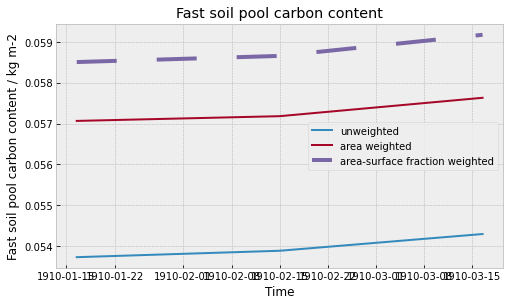

In [28]:
# NBVAL_IGNORE_OUTPUT
compare_weighting_options(csoilfast)

For land data, by default netCDF-SCM will use the area and surface fraction weights. Once again, if we turn the logging up, we can see the decisions being made internally.

In [29]:
# NBVAL_IGNORE_OUTPUT
root_logger.setLevel(logging.DEBUG)
csoilfast = CMIP6OutputCube()
csoilfast.load_data_from_path(csoilfast_file)

DEBUG:netcdf_scm.iris_cube_wrappers:loading cube ../../../tests/test-data/cmip6output/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r1i1p1f1/Lmon/cSoilFast/gr/v20180803/cSoilFast_Lmon_IPSL-CM6A-LR_historical_r1i1p1f1_gr_191001-191003.nc
DEBUG:netcdf_scm.iris_cube_wrappers:loading cube ../../../tests/test-data/cmip6output/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r1i1p1f1/fx/areacella/gr/v20180803/areacella_fx_IPSL-CM6A-LR_historical_r1i1p1f1_gr.nc


In [30]:
# NBVAL_IGNORE_OUTPUT
netcdf_scm_calculated = csoilfast.get_scm_timeseries(
    regions=["World"]
).timeseries()

netcdf_scm_calculated.T

DEBUG:netcdf_scm.iris_cube_wrappers:cell_weights: None
DEBUG:netcdf_scm.iris_cube_wrappers:self.netcdf_scm_realm: land
DEBUG:netcdf_scm.iris_cube_wrappers:Using: <class 'netcdf_scm.weights.AreaSurfaceFractionWeightCalculator'>
DEBUG:netcdf_scm.iris_cube_wrappers:loading cube ../../../tests/test-data/cmip6output/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r1i1p1f1/fx/sftlf/gr/v20180803/sftlf_fx_IPSL-CM6A-LR_historical_r1i1p1f1_gr.nc
DEBUG:netcdf_scm.weights:sftlf data max is 100.0, dividing by 100.0 to convert units to fraction
DEBUG:netcdf_scm.iris_cube_wrappers:Crunching SCM timeseries in memory
  warnings.warn(msg.format(self.name()))

  warnings.warn(msg.format(self.name()))



activity_id                                     CMIP
climate_model                           IPSL-CM6A-LR
member_id                                   r1i1p1f1
mip_era                                        CMIP6
model                                    unspecified
region                                         World
scenario                                  historical
unit                                         kg m^-2
variable                                   cSoilFast
variable_standard_name fast_soil_pool_carbon_content
time                                                
1910-01-16 12:00:00                         0.058512
1910-02-15 00:00:00                         0.058663
1910-03-16 12:00:00                         0.059181

## Atmosphere

Finally we look at atmospheric data.

In [31]:
tas = CMIP6OutputCube()
tas.load_data_from_path(tas_file)

DEBUG:netcdf_scm.iris_cube_wrappers:loading cube ../../../tests/test-data/cmip6output/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r1i1p1f1/Amon/tas/gr/v20180803/tas_Amon_IPSL-CM6A-LR_historical_r1i1p1f1_gr_191001-191003.nc
DEBUG:netcdf_scm.iris_cube_wrappers:loading cube ../../../tests/test-data/cmip6output/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r1i1p1f1/fx/areacella/gr/v20180803/areacella_fx_IPSL-CM6A-LR_historical_r1i1p1f1_gr.nc


In [32]:
tas.netcdf_scm_realm

'atmosphere'

If we have atmosphere data, then we have global coverage and so can split data into both the land and ocean boxes.

DEBUG:netcdf_scm.iris_cube_wrappers:cell_weights: None
DEBUG:netcdf_scm.iris_cube_wrappers:self.netcdf_scm_realm: atmosphere
DEBUG:netcdf_scm.iris_cube_wrappers:Using: <class 'netcdf_scm.weights.AreaSurfaceFractionWeightCalculator'>
DEBUG:netcdf_scm.iris_cube_wrappers:loading cube ../../../tests/test-data/cmip6output/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r1i1p1f1/fx/sftlf/gr/v20180803/sftlf_fx_IPSL-CM6A-LR_historical_r1i1p1f1_gr.nc
DEBUG:netcdf_scm.weights:sftlf data max is 100.0, dividing by 100.0 to convert units to fraction
DEBUG:netcdf_scm.iris_cube_wrappers:Crunching SCM timeseries in memory
  warnings.warn(msg.format(self.name()))

  warnings.warn(msg.format(self.name()))

  warnings.warn(msg.format(self.name()))

  warnings.warn(msg.format(self.name()))

  warnings.warn(msg.format(self.name()))

  warnings.warn(msg.format(self.name()))

  warnings.warn(msg.format(self.name()))

  warnings.warn(msg.format(self.name()))

  warnings.warn(msg.format(self.name()))

  warnings.warn(

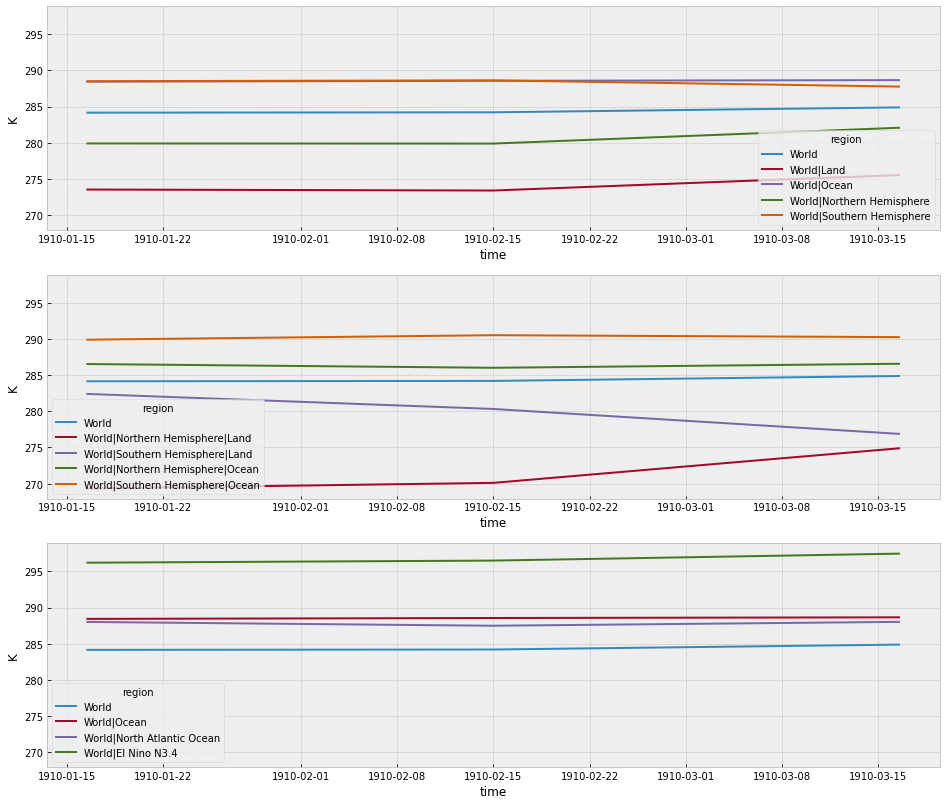

In [33]:
# NBVAL_IGNORE_OUTPUT
fig = plt.figure(figsize=(16, 14))
ax1 = fig.add_subplot(311)
tas.get_scm_timeseries(
    regions=[
        "World",
        "World|Land",
        "World|Ocean",
        "World|Northern Hemisphere",
        "World|Southern Hemisphere",
    ]
).lineplot(hue="region", ax=ax1)

ax2 = fig.add_subplot(312, sharey=ax1, sharex=ax1)
tas.get_scm_timeseries(
    regions=[
        "World",
        "World|Northern Hemisphere|Land",
        "World|Southern Hemisphere|Land",
        "World|Northern Hemisphere|Ocean",
        "World|Southern Hemisphere|Ocean",
    ]
).lineplot(hue="region", ax=ax2)

ax3 = fig.add_subplot(313, sharey=ax1, sharex=ax1)
tas.get_scm_timeseries(
    regions=[
        "World",
        "World|Ocean",
        "World|North Atlantic Ocean",
        "World|El Nino N3.4",
    ]
).lineplot(hue="region", ax=ax3);

  warnings.warn(msg.format(coord.name()))

  warnings.warn(msg.format(self.name()))

  warnings.warn(msg.format(self.name()))

  warnings.warn(msg.format(self.name()))

  warnings.warn(msg.format(self.name()))

  warnings.warn(msg.format(self.name()))

  warnings.warn(msg.format(self.name()))



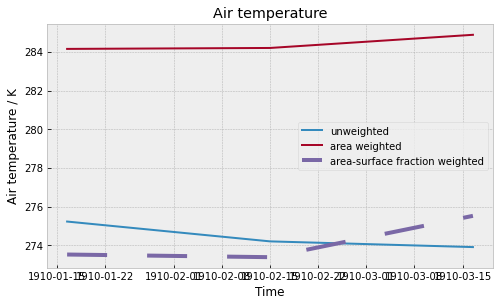

In [34]:
# NBVAL_IGNORE_OUTPUT
compare_weighting_options(tas)

As our data is global, the "World" data is simply an area-weighted mean.

In [35]:
# NBVAL_IGNORE_OUTPUT
tas_area = tas.get_metadata_cube(tas.areacell_var).cube

tas_area_weights = broadcast_onto_lat_lon_grid(tas, tas_area.data)
tas_area_weighted_mean = tas.cube.collapsed(
    ["latitude", "longitude"], iris.analysis.MEAN, weights=tas_area_weights
)

netcdf_scm_calculated = tas.get_scm_timeseries(regions=["World"]).timeseries()

np.testing.assert_allclose(
    tas_area_weighted_mean.data, netcdf_scm_calculated.values.squeeze()
)

netcdf_scm_calculated.T

  warnings.warn(msg.format(self.name()))

  warnings.warn(msg.format(self.name()))

DEBUG:netcdf_scm.iris_cube_wrappers:Crunching SCM timeseries in memory
  warnings.warn(msg.format(self.name()))

  warnings.warn(msg.format(self.name()))



activity_id                       CMIP
climate_model             IPSL-CM6A-LR
member_id                     r1i1p1f1
mip_era                          CMIP6
model                      unspecified
region                           World
scenario                    historical
unit                                 K
variable                           tas
variable_standard_name air_temperature
time                                  
1910-01-16 12:00:00         284.148122
1910-02-15 00:00:00         284.196805
1910-03-16 12:00:00         284.876555

The "World|Land" data is surface fraction weighted.

In [36]:
# NBVAL_IGNORE_OUTPUT
tas_sf = tas.get_metadata_cube(tas.surface_fraction_var).cube
# netcdf-scm normalises weights to 1 internally so we do so here too
tas_sf = tas_sf / tas_sf.data.max()


tas_area_sf = tas_area * tas_sf

tas_area_sf_weights = broadcast_onto_lat_lon_grid(tas, tas_area_sf.data)
tas_area_sf_weighted_mean = tas.cube.collapsed(
    ["latitude", "longitude"], iris.analysis.MEAN, weights=tas_area_sf_weights
)

netcdf_scm_calculated = tas.get_scm_timeseries(
    regions=["World|Land"]
).timeseries()

np.testing.assert_allclose(
    tas_area_sf_weighted_mean.data, netcdf_scm_calculated.values.squeeze()
)

netcdf_scm_calculated.T

  warnings.warn(msg.format(self.name()))

  warnings.warn(msg.format(self.name()))

DEBUG:netcdf_scm.iris_cube_wrappers:Crunching SCM timeseries in memory
  warnings.warn(msg.format(self.name()))

  warnings.warn(msg.format(self.name()))



activity_id                       CMIP
climate_model             IPSL-CM6A-LR
member_id                     r1i1p1f1
mip_era                          CMIP6
model                      unspecified
region                      World|Land
scenario                    historical
unit                                 K
variable                           tas
variable_standard_name air_temperature
time                                  
1910-01-16 12:00:00         273.530365
1910-02-15 00:00:00         273.393341
1910-03-16 12:00:00         275.527954

The "World|Ocean" data is also surface fraction weighted (calculated as 100 minus land surface fraction).

In [37]:
# NBVAL_IGNORE_OUTPUT
tas_sf_ocean = tas.get_metadata_cube(tas.surface_fraction_var).cube
tas_sf_ocean.data = 100 - tas_sf_ocean.data

# netcdf-scm normalises weights to 1 internally so we do so here too
tas_sf_ocean = tas_sf_ocean / tas_sf_ocean.data.max()

tas_area_sf_ocean = tas_area.data * tas_sf_ocean.data

tas_area_sf_ocean_weights = broadcast_onto_lat_lon_grid(tas, tas_area_sf_ocean)
tas_area_sf_ocean_weighted_mean = tas.cube.collapsed(
    ["latitude", "longitude"],
    iris.analysis.MEAN,
    weights=tas_area_sf_ocean_weights,
)

netcdf_scm_calculated = tas.get_scm_timeseries(
    regions=["World|Ocean"]
).timeseries()

np.testing.assert_allclose(
    tas_area_sf_ocean_weighted_mean.data,
    netcdf_scm_calculated.values.squeeze(),
)

netcdf_scm_calculated.T

  warnings.warn(msg.format(self.name()))

  warnings.warn(msg.format(self.name()))

DEBUG:netcdf_scm.iris_cube_wrappers:Crunching SCM timeseries in memory
  warnings.warn(msg.format(self.name()))

  warnings.warn(msg.format(self.name()))



activity_id                       CMIP
climate_model             IPSL-CM6A-LR
member_id                     r1i1p1f1
mip_era                          CMIP6
model                      unspecified
region                     World|Ocean
scenario                    historical
unit                                 K
variable                           tas
variable_standard_name air_temperature
time                                  
1910-01-16 12:00:00         288.427979
1910-02-15 00:00:00         288.551514
1910-03-16 12:00:00         288.644806

For atmosphere data, by default netCDF-SCM will use the area and surface fraction weights. Once again, if we turn the logging up, we can see the decisions being made internally.

In [38]:
# NBVAL_IGNORE_OUTPUT
root_logger.setLevel(logging.DEBUG)
tas = CMIP6OutputCube()
tas.load_data_from_path(tas_file)

DEBUG:netcdf_scm.iris_cube_wrappers:loading cube ../../../tests/test-data/cmip6output/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r1i1p1f1/Amon/tas/gr/v20180803/tas_Amon_IPSL-CM6A-LR_historical_r1i1p1f1_gr_191001-191003.nc
DEBUG:netcdf_scm.iris_cube_wrappers:loading cube ../../../tests/test-data/cmip6output/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r1i1p1f1/fx/areacella/gr/v20180803/areacella_fx_IPSL-CM6A-LR_historical_r1i1p1f1_gr.nc


In [39]:
# NBVAL_IGNORE_OUTPUT
netcdf_scm_calculated = tas.get_scm_timeseries(regions=["World"]).timeseries()

netcdf_scm_calculated.T

DEBUG:netcdf_scm.iris_cube_wrappers:cell_weights: None
DEBUG:netcdf_scm.iris_cube_wrappers:self.netcdf_scm_realm: atmosphere
DEBUG:netcdf_scm.iris_cube_wrappers:Using: <class 'netcdf_scm.weights.AreaSurfaceFractionWeightCalculator'>
DEBUG:netcdf_scm.iris_cube_wrappers:Crunching SCM timeseries in memory
  warnings.warn(msg.format(self.name()))

  warnings.warn(msg.format(self.name()))



activity_id                       CMIP
climate_model             IPSL-CM6A-LR
member_id                     r1i1p1f1
mip_era                          CMIP6
model                      unspecified
region                           World
scenario                    historical
unit                                 K
variable                           tas
variable_standard_name air_temperature
time                                  
1910-01-16 12:00:00         284.148122
1910-02-15 00:00:00         284.196805
1910-03-16 12:00:00         284.876555